Tancredi Bosi - tancredi.bosi@studio.unibo.it - 0001121897

### SET-UP SETTINGS
 - python 3.11 required
 - libraries to install
    - langroid
    - ftfy
    - selenium
    - numpy
    - bs4
 - load normattiva_scraper.py in the same folder (file slightly changed)

# MAIN PROJECT

## Import libraries

In [1]:
import langroid.language_models as lm
import langroid as lr
from langroid.utils.configuration import settings

import json
import ftfy
import time

import re
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from normattiva_scraper import NormattivaScraper

## Langroid llm configuration

**llm_config_AS**: LLM configuration for the AnswerScraper agent. It is designed to output at least 200 token being that it has to produce a useful answer.
**llm_config_AC**:LLM configuration for the AnswerCompiler agent It is designed to output at most 50 token, being that the answer has to be produced in the first tokens.

In [2]:
llm_config_AS = lm.OpenAIGPTConfig(
    chat_model="ollama/phi3.5",
    chat_context_length=16000,
    max_output_tokens=1000,
    min_output_tokens=200
)

llm_config_AC = lm.OpenAIGPTConfig(
    chat_model="ollama/phi3.5",
    chat_context_length=16000,
    max_output_tokens=50,
    min_output_tokens=1,
    temperature=0
)

# Avoid printing LLM responses at each call
settings.quiet = True

## Dataset dowload

Read the json file and store the data into a list of dictionaries. Collect only question, answer1, answer2, answer3 and correct_answer.

In [3]:
file_path = 'mcqa_codice_penale.json'
data = []
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            print(f"Skipping line: {line}")

filtered_data = [
    {
        "question": item.get("question"),
        "answer1": item.get("answer_1"),
        "answer2": item.get("answer_2"),
        "answer3": item.get("answer_3"),
        "correct_answer": item.get("correct_answer")
    }
    for item in data
]

## Dataset Cleaning

Clean the collected data:
 - fix the text in input to encode it in the right way with ftfy
 - remove non-alphanumeric or punctuation characters substituting them with a space character
 - lower the text

In [4]:
def clean_text(phrase):
    cleaned_phrase = ftfy.fix_text(phrase)
    cleaned_phrase = re.sub(r"[^\w.,;:!?'\-\"()\[\]\{\}\s]", " ", cleaned_phrase)    
    cleaned_phrase = cleaned_phrase.lower()
    return cleaned_phrase

for data in filtered_data:
    data['question'] = clean_text(data.get("question"))
    data['answer1'] = clean_text(data.get("answer1"))
    data['answer2'] = clean_text(data.get("answer2"))
    data['answer3'] = clean_text(data.get("answer3"))

## Reference Finder Agent

Agent that finds references in the given question, or searchs for them on Google if there are not in the question, .<br>
Methods:
 - **find_legal_references**: checks for legal references in the input string using regex.
 - **search_web_for_references**: Formulates a Google search query, scrapes titles and descriptions of search results and calls **find_legal_references**
 - **process_question**: agent's policy that calls **find_legal_references** and, if no reference is found, calls **search_web_for_references**. It than outputs the reference found.

In [5]:
RF_agent_config = lr.ChatAgentConfig(
    llm=llm_config_AC
)

class ReferenceFinder(lr.Agent):
    def __init__(self):
        super().__init__(config=RF_agent_config)
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        chrome_options.add_argument("--no-sandbox")
        chrome_options.add_argument("--disable-dev-shm-usage")
        self.driver = webdriver.Chrome(service=Service("/usr/local/bin/chromedriver"), options=chrome_options)

    def find_legal_references(self, sentence):
        """
        Checks for direct legal references in the input string using regex.
        """
        patterns = {
            "c.p.p.": "codice procedura penale (c.p.p.)",
            "codice di procedura penale": "codice procedura penale (c.p.p.)",
            "c.p.a.": "c.p.a.",
            "c.p.": "codice penale (c.p.)",
            "codice penale": "codice penale (c.p.)",
            "costituzione": "costituzione",
        }
        
        abbr_results = {full_form: False for full_form in patterns.values()}
        
        # Track the positions that have already been matched
        matched_positions = set()
        
        # Search for each pattern in the sentence
        for pattern, full_form in patterns.items():
            matches = re.finditer(re.escape(pattern), sentence)
            for match in matches:
                start, end = match.start(), match.end()
                if not any(pos in matched_positions for pos in range(start, end)):
                    abbr_results[full_form] = True
                    matched_positions.update(range(start, end))
        
        # Define regex patterns for number, year, article and comma
        number_pattern = r'\b(?:n\.?|l\.?|d\.lgs\.?)\s*(\d+)\b'
        year_pattern = r'\b(?:19|20)\d{2}\b'
        article_pattern = r'[^\w]*(?:artt?\.?|articolo)\s*(\d+)\b'
        comma_pattern = r'\bcomma\s+(\d+)\b'
        
        # Find all matches for number, year, article and comma
        numbers = re.findall(number_pattern, sentence)
        years = re.findall(year_pattern, sentence)
        articles = re.findall(article_pattern, sentence)
        commas = re.findall(comma_pattern, sentence)
        
        result = {}
        if numbers:
            result['number'] = numbers[0]
        if years:
            result['year'] = years[0]
        if articles:
            result['article_number'] = articles[0]
        if commas:
            result['comma'] = commas[0]
        else:
            result['comma'] = None

        if abbr_results.get("codice procedura penale (c.p.p.)"):
            result["number"] = 447
            result["year"] = 1988
        elif abbr_results.get("c.p.a."):
            result["number"] = 104
            result["year"] = 2010
        elif abbr_results.get("codice penale (c.p.)"):
            result["number"] = 1398
            result["year"] = 1930
        elif abbr_results.get("costituzione"):
            result["number"] = 0
            result["year"] = ''
        
        return result if result else None

    def search_web_for_references(self, query):
        """
        Formulates a Google search query and scrapes titles and descriptions of search results.
        """
        google_url = f"https://www.google.com/search?q={query}"
        self.driver.get(google_url)

        # Accept the consent if present
        try:
            consent_button = self.driver.find_element(By.XPATH, "//button[contains(text(), 'Accetta tutto')]")
            consent_button.click()
        except:
            pass

        soup = BeautifulSoup(self.driver.page_source, "html.parser")

        # Extract the title and description of search results
        titles = [item.get_text() for item in soup.find_all("h3")]
        descriptions = [item.get_text() for item in soup.find_all("span", class_="aCOpRe")]
        # print("Top Search Results:")
        # for title in titles:
        #     print(f" - {title}")
        combined_text = " ".join(titles[:5] + descriptions[:5])
        combined_text = clean_text(combined_text)
        web_references = self.find_legal_references(combined_text)
        return web_references

    def process_question(self, question):
        '''
        Process a question and return legal references.
        '''
        # Check for direct references in the question
        references = self.find_legal_references(question)

        # If no references, conduct a web search
        if not references:
            query = f"legal reference for {question}"
            web_references = self.search_web_for_references(query)
            return web_references
        else:
            return references
        
# EXAMPLE
# rf_agent = ReferenceFinder()
# question = "Le prove sono ammesse a richiesta di parte ex art. 190 c.p.p. Il giudice:"
# references = rf_agent.process_question(question)
# print(references)

## Normattiva Expert Agent

Agent responsible to call the NormattivaScraper functions to find legal text on https://www.normattiva.it given the input reference.

NOTE: NormattivaScraper has been modified to find also the "Codice Penale" articles.

In [6]:
NE_agent_config = lr.ChatAgentConfig(
    llm=llm_config_AC
)

class NormattivaExpert(lr.Agent):
    def __init__(self):
        super().__init__(config=NE_agent_config)
        self.scraper = NormattivaScraper('/usr/local/bin/chromedriver')

    def fetch_legal_text(self, reference):
        """
        Uses Normattiva scraper to retrieve legal text based on the reference.
        """
        try:
            law_number = reference["number"]
            year = reference["year"]
            art_number = reference['article_number']
            self.scraper.navigate_to_page("https://www.normattiva.it/ricerca/avanzata")
            text = self.scraper.get_article_text(law_number, year, art_number)
            self.scraper.close()
            final_text = ''
            if reference['comma'] is None:
                for comma in text['commas'].values():
                    final_text += comma + '\n'
            else:
                final_text = text['commas'][reference['comma']]
                
            if final_text:
                return final_text
            else:
                return None
        except Exception as e:
            return None

# # EXAMPLE
# normattiva_exp = NormattivaExpert()
# reference = {'article_number': '57', 'comma': None, 'number': 447, 'year': 1988}
# reference = {'article_number': '73', 'comma': None, 'number': 0, 'year': ''}
# reference = {'article_number': '35', 'comma': None, 'number': 1398, 'year': 1930}
# text = normattiva_exp.fetch_legal_text(reference)
# print(text)

## Define Answer Scraper Agent

Agent that reformulates the input question, performs a Google search, and produces an answer based on them.<br>
Methods:
 - **search_google**: performs a Google search given the query and returns the top-5 results
 - **clean_data**: cleans the content of the Google searches given in input and returns a list of dictionaries
 - **find_unique_answer**: gives the question and the data found on Google to the LLM and outputs a unique answer to the question.
 - **get_answer**: policy to perform the whole task using the methods explained before

In [7]:
AS_agent_config = lr.ChatAgentConfig(
    llm=llm_config_AS,
    system_message="Sei un agente che risponde in italiano con un testo completo e senza perdere dettagli \
         a una domanda, basandoti su i risultati di una ricerca google.",
)

class AnswerScraper(lr.ChatAgent):
    def __init__(self):
        super().__init__(config=AS_agent_config)
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        chrome_options.add_argument("--no-sandbox")
        chrome_options.add_argument("--disable-dev-shm-usage")
        chrome_options.add_experimental_option("prefs", {
            "download.prompt_for_download": False,
            "download.default_directory": "/dev/null",  # Non-existent directory to prevent downloads
            "profile.default_content_setting_values.automatic_downloads": 2,  # Block automatic downloads
        })
        self.driver = webdriver.Chrome(service=Service("/usr/local/bin/chromedriver"), options=chrome_options)
    
    def search_google(self, query):
        '''
        Perform a web search given a query. Returns the top 5 search results in a list.
        '''
        google_url = f"https://www.google.com/search?q={query}"
        self.driver.get(google_url)

        # Accept the consent if present
        try:
            consent_button = self.driver.find_element(By.XPATH, "//button[contains(text(), 'Accetta tutto')]")
            consent_button.click()
        except:
            pass

        soup = BeautifulSoup(self.driver.page_source, "html.parser")

        # Extracting titles, descriptions, and URLs
        results = []
        for result in soup.find_all("div", class_="tF2Cxc"):
            title = result.find("h3")
            description = result.find("div", class_="VwiC3b")
            link = result.find("a")
            if title and description and link:
                title_text = title.get_text()
                description_text = description.get_text()
                url = link['href']
                results.append({"title": title_text, "description": description_text, "url": url})

        # Visit each URL and extract page content
        for result in results[:5]:
            try:
                self.driver.get(result["url"])
                time.sleep(2)
                page_soup = BeautifulSoup(self.driver.page_source, "html.parser")
                page_text = page_soup.get_text(separator="\n").strip()
                result["content"] = page_text[:500]
            except Exception as e:
                result["content"] = "Failed to retrieve content"
        
        return results
    
    def clean_data(self, data):
        '''
        Clean web searches given in input.
        '''
        cleaned_results = []
        for item in data:
            cleaned_item = {}
            
            cleaned_item['title'] = item.get('title', '').strip()
            cleaned_item['description'] = item.get('description', '').strip()
            cleaned_item['url'] = item.get('url', '').strip()
            
            content = item.get('content', '').strip()
            # Reduce multiple new lines to one
            content = re.sub(r'\n+', '\n', content)
            # Remove multiple white spaces
            content = re.sub(r'\s{2,}', ' ', content)

            content = content[:300] + '...' if len(content) > 300 else content
            cleaned_item['content'] = content
            
            cleaned_results.append(cleaned_item)
        return cleaned_results

    def find_unique_answer(self, results, question):
        """
        Analize the search results to find a unique correct answer.
        """
        if not results:
            return None
        
        combined_text = " ".join([result['title'] + " " + result['description'] for result in results])
        combined_text = f"Domanda:'{question}'\n\
                        Ricerca web: {combined_text}"

        response = self.llm_response(combined_text)
        
        return response

    def get_answer(self, question):
        """
        Reformulates the question, performs a Google search, and returns the most relevant answer.
        """
        # Reformulate the question into a search query
        query = question.replace(" ", "+")

        # Perform the search and get top results
        results = self.search_google(query)
        results = self.clean_data(results)

        # Formulate a unique answer
        unique_answer = self.find_unique_answer(results, question)
        
        if unique_answer is None:
            return ""

        return str(unique_answer)[13:]

# EXAMPLE
# answer_scraper = AnswerScraper()
# question = "Le prove sono ammesse a richiesta di parte ex art. 190 c.p.p. Il giudice:"
# print("\nSearching for answers:")
# final_anser = answer_scraper.get_answer(question)
# print(final_anser)

## Define Answer Compiler Agent

Agent that takes the input (question, choices, legal text, Google answer) to make it process to an LLM and then extracts the answered choice from the LLM response: 1,2, 3 or 0 (if None is found)

In [8]:
AC_agent_config = lr.ChatAgentConfig(
    llm=llm_config_AC,
    system_message="Sei un agente incaricato di rispondere in italiano a una domanda selezionando la risposta corretta tra tre opzioni fornite.\
                    Rispondi immediatamente e unicamente con il numero (1, 2 o 3) corrispondente alla risposta giusta, senza aggiungere commenti o spiegazioni.\
                    La tua risposta deve essere solo il numero della risposta corretta.\
                    Baserai la tua scelta esclusivamente sui seguenti input:\n \
                        - domanda\n \
                        - opzioni\n \
                        - testo normativo\n \
                        - risposta google",
)

class AnswerCompiler(lr.ChatAgent):
    def __init__(self):
        super().__init__(config=AC_agent_config)

    def compile_answer(self, final_answer, final_text, question, choices):
        """
        Uses the LLM to compare the final_answer and final_text with the given choices and returns the correct answer.
        """

        combined_text = (f"domanda:{question}\n"
                    F"opzioni:\n"
                    f"1) {choices[0]}\n"
                    f"2) {choices[1]}\n"
                    f"3) {choices[2]}\n\n"
                    f"testo normativo: {final_text}\n\n"
                    f"risposta google: {final_answer}\n\n"
                )

        response = self.llm_response(combined_text)
        response = str(response)[12:]

        # Extract the number of the correct answer from the response using regex
        correct_answer_number = None
        pattern = r'\b([123])\b'

       # Search for the answer where it should be 
        match = re.search(pattern, response[:5])
        if match:
            correct_answer_number = match.group(1)
        else:
            # Check the whole response in case the LLM does not immediatly respond with the number of the answer
            match = re.search(pattern, response)
            if match:
                correct_answer_number = match.group(1)
        if correct_answer_number is None:
            correct_answer_number = 0
        correct_answer_number = int(correct_answer_number)
        return correct_answer_number, response
    
# # EXAMPLE
# answer_compiler = AnswerCompiler()
# final_answer = "Secondo l'articolo 190 del codice di procedura penale, il giudice è obbligato a ammettere le prove su richiesta delle parti coinvolte in una causa. Il giudice deve prendere questa decisione senza ritardo e escludere eventuali prove proibite dalla legge o quelle che evidentemente non sono rilevanti per il caso in questione, come stabilito anche dall'articolo 495 del medesimo codice. Questo principio rappresenta un fondamentale aspetto dell'istituto accusatorio nel nostro sistema processuale penale ed è inteso a garantire che entrambe le parti abbiano pari opportunità nell'accumulare prove per la loro difesa o l'accusa, rispettando così il principio di equo giusto procedimento.""
# final_text = "1. Le prove sono ammesse a richiesta di parte. Il giudice provvede senza ritardo con ordinanza escludendo le prove vietate dalla legge e quelle che manifestamente sono superflue o irrilevanti. 2. La legge stabilisce i casi in cui le prove sono ammesse di ufficio. 3. I provvedimenti sull'ammissione della prova possono essere revocati sentite le parti in contraddittorio."
# question = "Le prove sono ammesse a richiesta di parte ex art. 190 c.p.p. Il giudice:"
# choices = ["provvede entro trenta giorni con ordinanza comprendendo anche le prove manifestamente superflue o irrilevanti per stralciarle in sede di udienza", "provvede senza ritardo con ordinanza escludendo le prove vietate dalla legge e quelle che manifestamente sono superflue o irrilevanti", "provvede senza ritardo con decreto escludendo le prove vietate dalla legge e quelle che manifestamente sono superflue"]
# correct_answer = answer_compiler.compile_answer(final_answer, final_text, question, choices)
# print(f"Correct answer: {correct_answer}")

## Create the Agents Pipeline

Policy to make the agents interact and produce an answer.

In [9]:
def agents_pipeline(single_data):
    '''
    Policy to make the agents interact and produce an answer.
    '''
    regulatory_agent = ReferenceFinder()
    normattiva_exp = NormattivaExpert()
    answer_scraper = AnswerScraper()
    answer_compiler = AnswerCompiler()

    reference = regulatory_agent.process_question(single_data['question'])
    if reference:
        normattiva_text = normattiva_exp.fetch_legal_text(reference)
        if normattiva_text is None:
            normattiva_text = ''
    else:
        normattiva_text = ''
    final_answer = answer_scraper.get_answer(single_data['question'])
    
    correct_answer, llm_response = answer_compiler.compile_answer(final_answer, normattiva_text, single_data['question'], [single_data['answer1'], single_data['answer2'], single_data['answer3']])
    
    answer_compiler.clear_history()
    answer_scraper.clear_history()
    return correct_answer, llm_response, reference, normattiva_text, final_answer

# # EXAMPLE
# single_data = filtered_data[0]
# correct_answer, llm_resp, ref, finaltext, finalanswer = process_single_data(single_data)
# print(f"Correct answer: {correct_answer}")
# print(f"LLM response: {llm_resp}")
# print(f"Legal reference: {ref}")
# print(f"Final text: {finaltext}")
# print(f"Final answer: {finalanswer}")

## Experiment Results

Evaluate the agent's pipeline on the dataset saving the results in a .txt file.

In [ ]:
def evaluate_data(filtered_data, out_file):
    '''
    Evaluate the agent's pipeline on the dataset saving the results in a .txt file.
    '''
    correct_predictions = 0
    total_questions = len(filtered_data)

    for idx, data in enumerate(filtered_data):
        correct_answer = int(data['correct_answer'])
        predicted_answer, llm_response, reference, final_text, final_answer = agents_pipeline(data)
        if predicted_answer == correct_answer:
            correct_predictions += 1

        with open(out_file, "a") as f:
            f.write(f"DOMANDA {idx}: {data['question']}\n")
            f.write(f"SCELTE:\n1) {data['answer1']}\n2) {data['answer2']}\n3) {data['answer3']}\n")
            f.write(f"RISPOSTA CORRETTA: {correct_answer}\n\n")
            f.write(f"REFERENCE: {reference}\n\n")
            f.write(f"TESTO NORMATTIVA: {final_text}\n\n")
            f.write(f"RISPOSTA DA GOOGLE: {final_answer}\n\n")
            f.write(f"RISPOSTA LLM: {llm_response}\n\n")
            f.write(f"RISPOSTA FINALE: {predicted_answer}\n\n")
            f.write(f"RISPOSTE CORRETTE: {correct_predictions}/{idx+1}\n\n")
            f.write(200*'-')
            f.write("\n\n")

    accuracy = (correct_predictions / total_questions) * 100
    with open(out_file, "a") as f:
        f.write(f"ACCURACY: {accuracy:.2f}%\n\n")

output_file_main = "risposte_main.txt"

with open(output_file_main, "w") as f:
    f.write("")

evaluate_data(filtered_data, output_file_main)

## Visualize the results

In [10]:
def extract_dataframe_results(file_path):
    """
    Reads the file in the file_path and returns a DataFrame with all questions,
    excluding the last line if it contains the total accuracy. Also, returns the total accuracy separately.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    # Split the content into individual questions using the separator line
    questions = content.strip().split('\n' + '-' * 200 + '\n\n')

    last_entry = questions[-1]
    accuracy_match = re.search(r'ACCURACY:\s*([\d\.]+)%', last_entry)
    if accuracy_match:
        total_accuracy = float(accuracy_match.group(1))
        questions = questions[:-1]
    else:
        total_accuracy = None

    records = []

    for q in questions:
        if not q.strip():
            continue

        idx_match = re.search(r'DOMANDA (\d+):', q)
        idx = int(idx_match.group(1)) if idx_match else None

        question_match = re.search(r'DOMANDA \d+: (.*?)\n', q, re.DOTALL)
        question_text = question_match.group(1).strip() if question_match else ''

        choices_match = re.search(r'SCELTE:\n1\)(.*?)\n2\)(.*?)\n3\)(.*?)\n', q, re.DOTALL)
        if choices_match:
            choices = [choices_match.group(i).strip() for i in range(1, 4)]
        else:
            choices = []

        correct_answer_match = re.search(r'RISPOSTA CORRETTA:\s*(\d+)', q)
        correct_answer = int(correct_answer_match.group(1)) if correct_answer_match else None

        predicted_answer_match = re.search(r'RISPOSTA FINALE:\s*(\d+)', q)
        predicted_answer = int(predicted_answer_match.group(1)) if predicted_answer_match else None

        llm_response_match = re.search(r'RISPOSTA LLM:\s*(.*?)\n\n', q, re.DOTALL)
        llm_response = llm_response_match.group(1).strip() if llm_response_match else ''

        is_correct = None
        if correct_answer is not None and predicted_answer is not None:
            is_correct = (correct_answer == predicted_answer)

        record = {
            'Index': idx,
            'Question': question_text,
            'Choices': choices,
            'Correct Answer': correct_answer,
            'Predicted Answer': predicted_answer,
            'Is Correct': is_correct,
            'LLM Response': llm_response
        }
        records.append(record)

    df_all = pd.DataFrame(records)

    return df_all, total_accuracy

In [11]:
def visualize_results(df):
    '''
    Plot confusion matrix, distribution of incorrect predictions and correct/incorrect answers.
    '''

    # CONFUSION MATRIX
    conf_mat = confusion_matrix(df['Correct Answer'], df['Predicted Answer'], labels=[1, 2, 3, 0])
    conf_mat_df = pd.DataFrame(conf_mat, index=['True:1', 'True:2', 'True:3', 'True:0'], columns=['Pred:1', 'Pred:2', 'Pred:3', 'Pred:0'])
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix of Predictions')
    axes[0].set_xlabel('Predicted Answer')
    axes[0].set_ylabel('Correct Answer')

    # DISTRIBUTION OF CORRECT AND INCORRECT PREDICTIONS
    df_incorrect = df[df['Is Correct'] == False]
    incorrect_counts = df_incorrect['Predicted Answer'].value_counts().sort_index()
    incorrect_counts = df_incorrect['Predicted Answer'].value_counts().sort_index()

    sns.barplot(x=incorrect_counts.index.astype(str), y=incorrect_counts.values, hue=incorrect_counts.index.astype(str), palette='Reds', ax=axes[1])
    axes[1].set_xlabel('Predicted Answer (Incorrect Predictions)')
    axes[1].set_ylabel('Number of Occurrences')
    axes[1].set_title('Distribution of Incorrect Predicted Answers')
    # Show counts on top of each bar
    for i, v in enumerate(incorrect_counts.values):
        axes[1].text(i, v + 0.5, str(v), ha='center')
    plt.ylim(0, max(incorrect_counts) + 2)
    plt.tight_layout()
    plt.show()

    # VISUALIZATION OF CORRECT AND INCORRECT ANSWERS
    df_sorted = df.sort_values('Index')
    colors = ['green' if is_correct else 'red' for is_correct in df_sorted['Is Correct']]

    plt.figure(figsize=(14, 2))
    plt.scatter(df_sorted['Index'], [1]*len(df_sorted), c=colors, s=100)

    plt.xlabel('Question Number')
    plt.title('Results: Correct (Green) and Incorrect (Red) Answers')
    plt.yticks([])
    plt.ylim(0.95, 1.05)
    plt.xlim(-1, df['Index'].max() + 1)
    plt.grid(axis='x')

    plt.tight_layout()
    plt.show()

Total accuracy: 64.79%


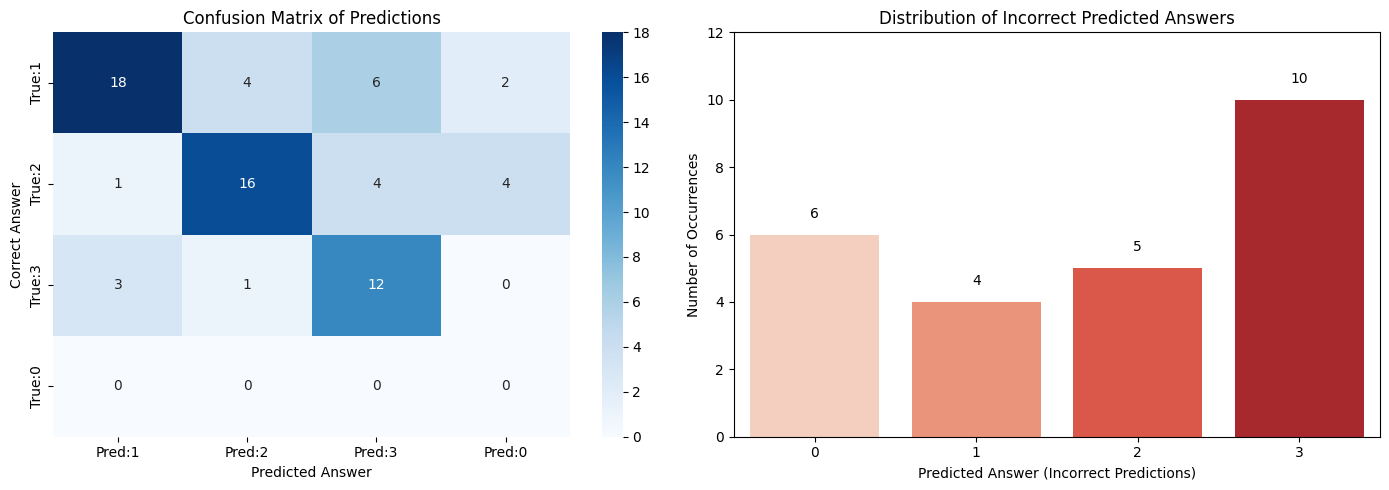

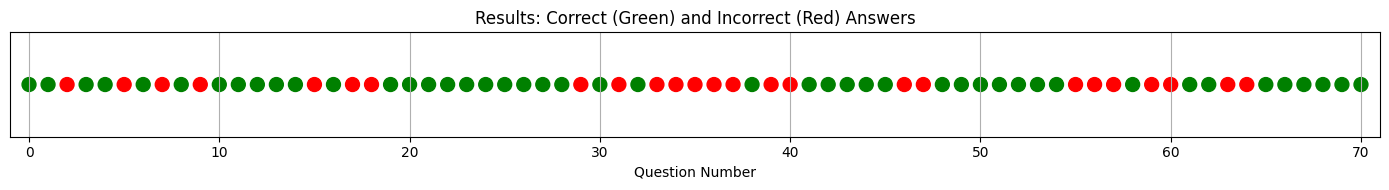

In [12]:
output_file_main = "risposte_main.txt"
df_main, accuracy_main = extract_dataframe_results(output_file_main)
print(f"Total accuracy: {accuracy_main}%")
visualize_results(df_main)

We can see that there is an high amount of LLM responses that do not produce an explicit answer and therefore is classified as 0, leading to loose something in performance terms. <br>
Beside of that, the performances achieved are good, considering the fact that the LLM used by the agents is not specialized in legal domain, and in particular in italian legal domain.

In [13]:
def print_errors_with_predicted_label_zero(df):
    """
    Prints the errors in the DataFrame where the predicted label is 0.
    """
    df_errors = df[df['Predicted Answer'] == 0]

    if df_errors.empty:
        print("No errors with predicted label 0.")
        return

    for _, row in df_errors.iterrows():
        print(f"Question {row['Index']}: {row['Question']}\n")
        print("Choices:")
        for i, choice in enumerate(row['Choices'], start=1):
            print(f"{i}) {choice}")
        print(f"\nCorrect Answer: {row['Correct Answer']}")
        print(f"Predicted Answer: {row['Predicted Answer']}\n")
        print(f"LLM Response:\n{row['LLM Response']}\n")
        print('-' * 80)

print_errors_with_predicted_label_zero(df_main)

Question 5: a norma di quanto dispone l'art. 133 del c.p.a., salvo ulteriori previsioni di legge, a chi sono devolute le controversie aventi ad oggetto i provvedimenti relativi alla disciplina o al divieto dell'esercizio d'industrie insalubri o pericolose?

Choices:
1) alla giurisdizione esclusiva del giudice ordinario.
2) alla giurisdizione esclusiva del giudice amministrativo.
3) alla giurisdizione esclusiva del tar del lazio.

Correct Answer: 2
Predicted Answer: 0

LLM Response:
risposta google: La ricerca web conferma che le controversie relative al divieto o alla disciplina dell'esercizio di industrie insalubri sono esclusivamente competenza del Giudice Amministr

--------------------------------------------------------------------------------
Question 7: l'art. 6 della l. n. 241 1990, in sede di specificazione dei compiti primari del responsabile del procedimento, dispone espressamente che il responsabile:

Choices:
1) non è competente all'adozione del provvedimento finale.
2) pr

# ABLATION STUDIES

## LLM without agents

I have decided to perform two analysis of the LLM prompts without agents, being very fast to evaluate:
 1) Ask the LLM to answer only with the number of the predicted choice.
 2) Ask the LLM to produce a sentence to make it produce some content and, after that, produce the number of the predicted choice after a tag [RES]

#### 1) Ask the LLM to answer only with the number of the predicted choice.

In [ ]:
def get_response_no_agents(data):
    basic_agent = lr.ChatAgent(lr.ChatAgentConfig(llm=llm_config_AC,
                                                  system_message="Sei un agente incaricato di rispondere in italiano a una domanda selezionando la risposta corretta tra tre opzioni fornite.\
                    Rispondi immediatamente e unicamente con il numero (1, 2 o 3) corrispondente alla risposta giusta, senza aggiungere commenti o spiegazioni.\
                    La tua risposta deve essere solo il numero della risposta corretta.\
                    Baserai la tua scelta esclusivamente sui seguenti input:\n \
                        - domanda\n \
                        - opzioni\n"
    ))

    combined_text = (f"domanda: {data.get('question')}\n"
                    f"opzioni:\n"
                    f"1) {data.get('answer1')}\n"
                    f"2) {data.get('answer2')}\n"
                    f"3) {data.get('answer3')}")
    response = basic_agent.llm_response(combined_text)
    response = str(response)[12:]

    correct_answer_number = None
    pattern = r'\b([123])\b'

    match = re.search(pattern, response[:5])
    if match:
        correct_answer_number = match.group(1)
    else:
        match = re.search(pattern, response)
        if match:
            correct_answer_number = match.group(1)
    if correct_answer_number is None:
        correct_answer_number = 0
    correct_answer_number = int(correct_answer_number)
    return correct_answer_number, response

def evaluate_data(filtered_data, out_file):
    correct_predictions = 0
    total_questions = len(filtered_data)

    for idx, data in enumerate(filtered_data):
        correct_answer = int(data['correct_answer'])
        predicted_answer, llm_response = get_response_no_agents(data)
        if predicted_answer == correct_answer:
            correct_predictions += 1

        with open(out_file, "a") as f:
            f.write(f"DOMANDA {idx}: {data['question']}\n")
            f.write(f"SCELTE:\n1) {data['answer1']}\n2) {data['answer2']}\n3) {data['answer3']}\n")
            f.write(f"RISPOSTA CORRETTA: {correct_answer}\n\n")
            f.write(f"RISPOSTA LLM: {llm_response}\n\n")
            f.write(f"RISPOSTA FINALE: {predicted_answer}\n\n")
            f.write(f"RISPOSTE CORRETTE: {correct_predictions}/{idx+1}\n\n")
            f.write(200*'-')
            f.write("\n\n")

    accuracy = (correct_predictions / total_questions) * 100
    with open(out_file, "a") as f:
        f.write(f"ACCURACY: {accuracy:.2f}%\n\n")

output_file_no_agents_1 = "risposte_no_agents_1.txt"

with open(output_file_no_agents_1, "w") as f:
    f.write("")

evaluate_data(filtered_data, output_file_no_agents_1)

Total accuracy: 53.52%


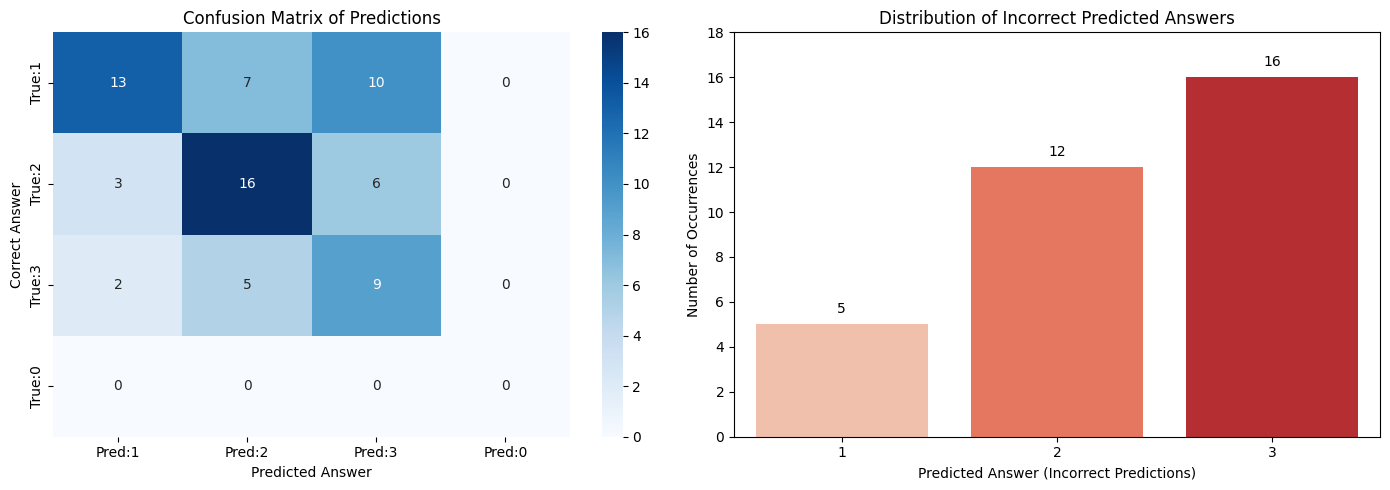

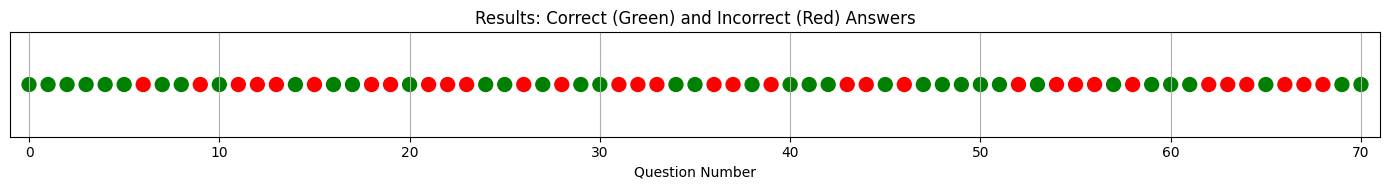

In [14]:
output_file_no_agents_1 = "risposte_no_agents_1.txt"
df_no_agents_1, accuracy_no_agents_1 = extract_dataframe_results(output_file_no_agents_1)
print(f"Total accuracy: {accuracy_no_agents_1}%")
visualize_results(df_no_agents_1)

#### 2) Ask the LLM to produce a sentence to make it write some content and, after that, produce the number of the predicted choice after a tag [RES]

In [ ]:
llm_config_ACRE = lm.OpenAIGPTConfig(
    chat_model="ollama/phi3.5",
    chat_context_length=32000,
    max_output_tokens=400,
    min_output_tokens=50,
    temperature=0
)

def get_response_no_agents(data):
    basic_agent = lr.ChatAgent(lr.ChatAgentConfig(llm=llm_config_ACRE,
                                                  system_message="Sei un agente incaricato di rispondere ad una domanda in italiano con una sola frase elaborata e corretta. Poi scrivi solo il numero dell'opzione corretta dopo il tag [RES].\
                    Baserai la tua scelta esclusivamente sui seguenti input:\n\
                        - domanda\n\
                        - opzioni\n\n\
                    ESEMPIO DI OUTPUT:\n\
                        frase chiara e corretta. \n\
                        [RES] 1",
    ))

    combined_text = (f"domanda: {data.get('question')}\n"
                    f"opzioni:\n"
                    f"1) {data.get('answer1')}\n"
                    f"2) {data.get('answer2')}\n"
                    f"3) {data.get('answer3')}\n\n"
                    f"rispondi con una frase e poi con il numero della risposta corretta tra 1, 2 e 3 dopo il tag [RES].")
    response = basic_agent.llm_response(combined_text)
    response = str(response)[12:]

    correct_answer_number = None
    pattern = r'\[RES\]\s*[:\s]*\s*(\d+)'

    match = re.search(pattern, response)
    if match:
        correct_answer_number = match.group(1)
    if correct_answer_number is None:
        pattern = r'\s([123])\s'
        match = re.search(pattern, response)
        if match:
            correct_answer_number = match.group(1)
    if correct_answer_number is None:
        correct_answer_number = 0
    correct_answer_number = int(correct_answer_number)
    return correct_answer_number, response

def evaluate_data(filtered_data, out_file):
    correct_predictions = 0
    total_questions = len(filtered_data)

    for idx, data in enumerate(filtered_data):
        correct_answer = int(data['correct_answer'])
        predicted_answer, llm_response = get_response_no_agents(data)
        if predicted_answer == correct_answer:
            correct_predictions += 1

        with open(out_file, "a") as f:
            f.write(f"DOMANDA {idx}: {data['question']}\n")
            f.write(f"SCELTE:\n1) {data['answer1']}\n2) {data['answer2']}\n3) {data['answer3']}\n")
            f.write(f"RISPOSTA CORRETTA: {correct_answer}\n\n")
            f.write(f"RISPOSTA LLM: {llm_response}\n\n")
            f.write(f"RISPOSTA FINALE: {predicted_answer}\n\n")
            f.write(f"RISPOSTE CORRETTE: {correct_predictions}/{idx+1}\n\n")
            f.write(200*'-')
            f.write("\n\n")

    accuracy = (correct_predictions / total_questions) * 100
    with open(out_file, "a") as f:
        f.write(f"ACCURACY: {accuracy:.2f}%\n\n")

output_file_no_agents_2 = "risposte_no_agents_2.txt"

with open(output_file_no_agents_2, "w") as f:
    f.write("")

evaluate_data(filtered_data, output_file_no_agents_2)

Total accuracy: 46.48%


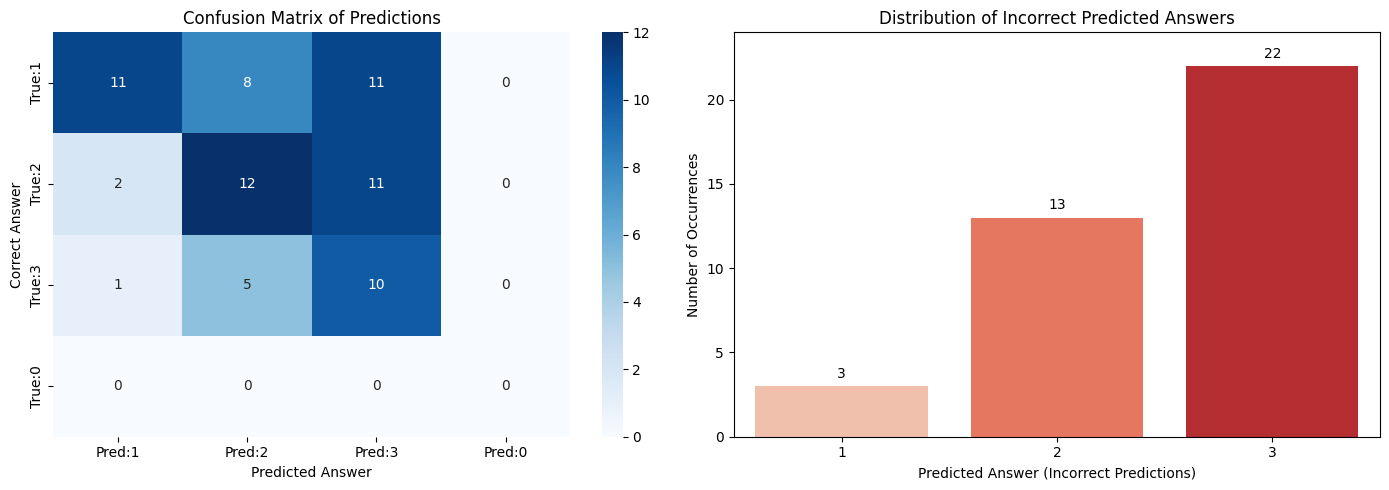

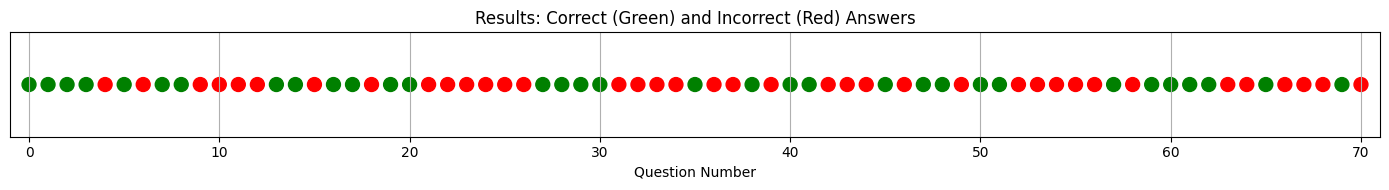

In [15]:
output_file_no_agents_2 = "risposte_no_agents_2.txt"
df_no_agents_2, accuracy_no_agents_2 = extract_dataframe_results(output_file_no_agents_2)
print(f"Total accuracy: {accuracy_no_agents_2}%")
visualize_results(df_no_agents_2)

## No Normattiva Text

In [ ]:
ACNN_agent_config = lr.ChatAgentConfig(
    llm=llm_config_AC,
    system_message="Sei un agente incaricato di rispondere in italiano a una domanda selezionando la risposta corretta tra tre opzioni fornite.\
                    Rispondi immediatamente e unicamente con il numero (1, 2 o 3) corrispondente alla risposta giusta, senza aggiungere commenti o spiegazioni.\
                    La tua risposta deve essere solo il numero della risposta corretta.\
                    Baserai la tua scelta esclusivamente sui seguenti input:\n \
                        - domanda\n \
                        - opzioni\n \
                        - risposta google",
)

class AnswerCompilerNoNormattiva(lr.ChatAgent):
    def __init__(self):
        super().__init__(config=ACNN_agent_config)

    def compile_answer(self, final_answer, question, choices):
        """
        Uses the LLM to compare the final_answer with the given choices and returns the correct answer.
        """
        combined_text = (f"domanda:{question}\n"
                    F"opzioni:\n"
                    f"1) {choices[0]}\n"
                    f"2) {choices[1]}\n"
                    f"3) {choices[2]}\n\n"
                    f"risposta google: {final_answer}\n\n"
                )

        response = self.llm_response(combined_text)
        response = str(response)[12:]

        correct_answer_number = None
        pattern = r'\b([123])\b'
    
        match = re.search(pattern, response[:5])
        if match:
            correct_answer_number = match.group(1)
        else:
            match = re.search(pattern, response)
            if match:
                correct_answer_number = match.group(1)
        if correct_answer_number is None:
            correct_answer_number = 0
        correct_answer_number = int(correct_answer_number)
        return correct_answer_number, response

In [ ]:
def agents_pipeline_no_normattiva(single_data):
    answer_scraper = AnswerScraper()
    answer_compiler = AnswerCompilerNoNormattiva()

    final_answer = answer_scraper.get_answer(single_data['question'])
    correct_answer, llm_response = answer_compiler.compile_answer(final_answer, single_data['question'], [single_data['answer1'], single_data['answer2'], single_data['answer3']])
    answer_compiler.clear_history()
    answer_scraper.clear_history()
    return correct_answer, llm_response, final_answer

def evaluate_data_no_normattiva(filtered_data, out_file):
    correct_predictions = 0
    total_questions = len(filtered_data)

    for idx, data in enumerate(filtered_data):
        
        correct_answer = int(data['correct_answer'])
        
        predicted_answer, llm_response, final_answer = agents_pipeline_no_normattiva(data)
        if predicted_answer == correct_answer:
            correct_predictions += 1

        with open(out_file, "a") as f:
            f.write(f"DOMANDA {idx}: {data['question']}\n")
            f.write(f"SCELTE:\n1) {data['answer1']}\n2) {data['answer2']}\n3) {data['answer3']}\n")
            f.write(f"RISPOSTA CORRETTA: {correct_answer}\n\n")
            f.write(f"RISPOSTA DA GOOGLE: {final_answer}\n\n")
            f.write(f"RISPOSTA LLM: {llm_response}\n\n")
            f.write(f"RISPOSTA FINALE: {predicted_answer}\n\n")
            f.write(f"RISPOSTE CORRETTE: {correct_predictions}/{idx+1}\n\n")
            f.write(200*'-')
            f.write("\n\n")

    accuracy = (correct_predictions / total_questions) * 100
    with open(out_file, "a") as f:
        f.write(f"ACCURACY: {accuracy:.2f}%\n\n")

output_file_no_normattiva = "risposte_no_normattiva.txt"

with open(output_file_no_normattiva, "w") as f:
    f.write("")

evaluate_data_no_normattiva(filtered_data, output_file_no_normattiva)

Total accuracy: 64.79%


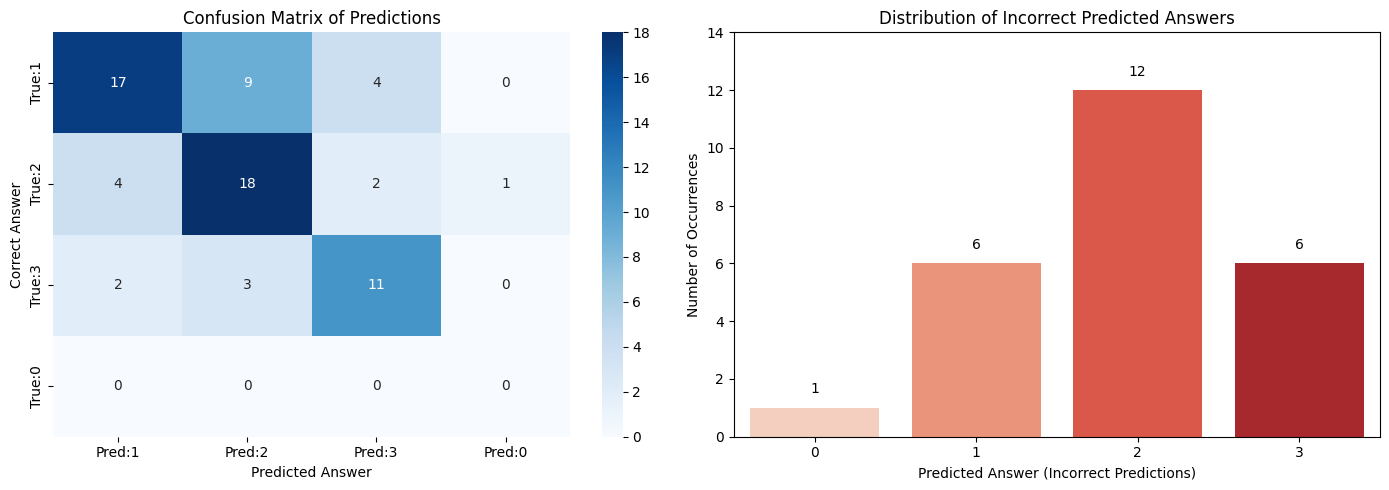

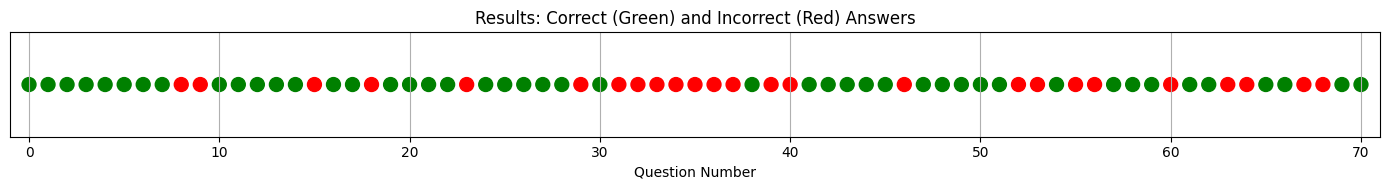

In [16]:
output_file_no_normattiva = "risposte_no_normattiva.txt"
df_no_normattiva, accuracy_no_normattiva = extract_dataframe_results(output_file_no_normattiva)
print(f"Total accuracy: {accuracy_no_normattiva}%")
visualize_results(df_no_normattiva)

## No Google Web Search

In [ ]:
ACNG_agent_config = lr.ChatAgentConfig(
    llm=llm_config_AC,
    system_message="Sei un agente incaricato di rispondere in italiano a una domanda selezionando la risposta corretta tra tre opzioni fornite.\
                    Rispondi immediatamente e unicamente con il numero (1, 2 o 3) corrispondente alla risposta giusta, senza aggiungere commenti o spiegazioni.\
                    La tua risposta deve essere solo il numero della risposta corretta.\
                    Baserai la tua scelta esclusivamente sui seguenti input:\n \
                        - domanda\n \
                        - opzioni\n \
                        - testo normativo"
)

class AnswerCompilerNoGoogle(lr.ChatAgent):
    def __init__(self):
        super().__init__(config=ACNG_agent_config)

    def compile_answer(self, final_text, question, choices):
        """
        Uses the LLM to compare the final_answer and final_text with the given choices and returns the correct answer.
        """
        # Combine final_answer and final_text for comparison
        combined_text = (f"domanda:{question}\n"
                    F"opzioni:\n"
                    f"1) {choices[0]}\n"
                    f"2) {choices[1]}\n"
                    f"3) {choices[2]}\n\n"
                    f"testo normativo: {final_text}"
                )

        # Use the LLM to determine the correct answer
        response = self.llm_response(combined_text)
        response = str(response)[12:]

        # Extract the number of the correct answer from the response using regex
        correct_answer_number = None
        pattern = r'\b([123])\b'
    
        # Search for the pattern in the text
        match = re.search(pattern, response[:5])
        if match:
            correct_answer_number = match.group(1)
        else:
            # Check the whole response in case the LLM does not immediatly respond with the number of the answer
            match = re.search(pattern, response)
            if match:
                correct_answer_number = match.group(1)
        if correct_answer_number is None:
            correct_answer_number = 0
        correct_answer_number = int(correct_answer_number)
        return correct_answer_number, response

In [ ]:
def agents_pipeline_no_google(single_data):
    regulatory_agent = ReferenceFinder()
    normattiva_exp = NormattivaExpert()
    answer_compiler = AnswerCompilerNoGoogle()
    reference = regulatory_agent.process_question(single_data['question'])
    if reference:
        normattiva_text = normattiva_exp.fetch_legal_text(reference)
        if normattiva_text is None:
            normattiva_text = ''
    else:
        normattiva_text = ''
    correct_answer, llm_response = answer_compiler.compile_answer(normattiva_text, single_data['question'], [single_data['answer1'], single_data['answer2'], single_data['answer3']])
    answer_compiler.clear_history()
    return correct_answer, llm_response, reference, normattiva_text

def evaluate_data_no_google(filtered_data, out_file):
    correct_predictions = 0
    total_questions = len(filtered_data)

    for idx, data in enumerate(filtered_data):
        
        correct_answer = int(data['correct_answer'])
        
        predicted_answer, llm_response, reference, final_text = agents_pipeline_no_google(data)
        if predicted_answer == correct_answer:
            correct_predictions += 1

        # Write the results to risposte.txt
        with open(out_file, "a") as f:
            f.write(f"DOMANDA {idx}: {data['question']}\n")
            f.write(f"SCELTE:\n1) {data['answer1']}\n2) {data['answer2']}\n3) {data['answer3']}\n")
            f.write(f"RISPOSTA CORRETTA: {correct_answer}\n\n")
            f.write(f"REFERENCE: {reference}\n\n")
            f.write(f"TESTO NORMATTIVA: {final_text}\n\n")
            f.write(f"RISPOSTA LLM: {llm_response}\n\n")
            f.write(f"RISPOSTA FINALE: {predicted_answer}\n\n")
            f.write(f"RISPOSTE CORRETTE: {correct_predictions}/{idx+1}\n\n")
            f.write(200*'-')
            f.write("\n\n")

    accuracy = (correct_predictions / total_questions) * 100
    with open(out_file, "a") as f:
        f.write(f"ACCURACY: {accuracy:.2f}%\n\n")

output_file_no_google = "risposte_no_google.txt"

with open(output_file_no_google, "w") as f:
    f.write("")

evaluate_data_no_google(filtered_data, output_file_no_google)

Total accuracy: 63.38%


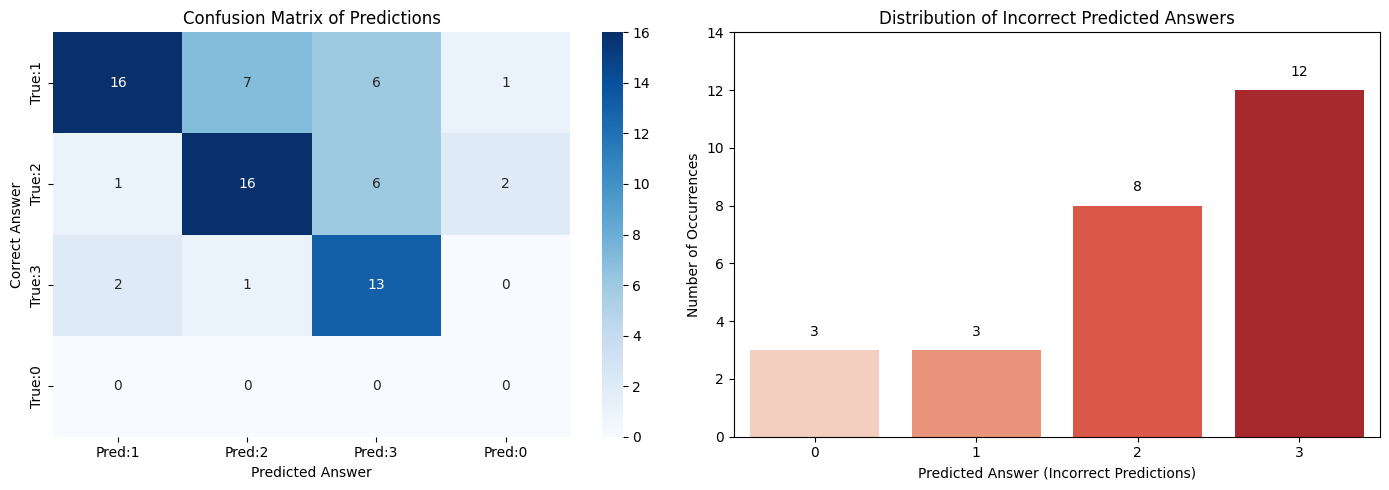

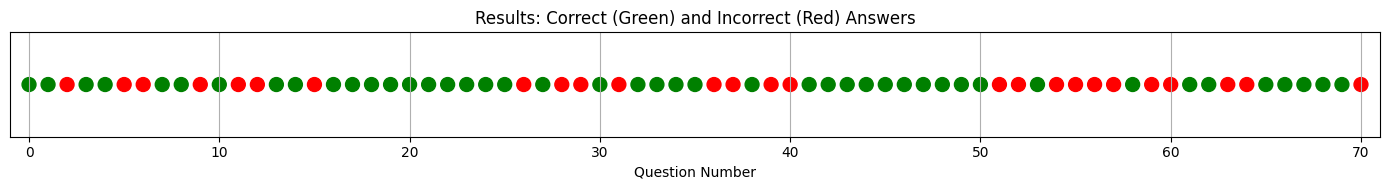

In [17]:
output_file_no_google = "risposte_no_google.txt"
df_no_google, accuracy_no_google = extract_dataframe_results(output_file_no_google)
print(f"Total accuracy: {accuracy_no_google}%")
visualize_results(df_no_google)

## Answer after a tag

In [ ]:
llm_config_ACRE = lm.OpenAIGPTConfig(
    chat_model="ollama/phi3.5",
    chat_context_length=32000,
    max_output_tokens=400,
    min_output_tokens=50,
    temperature=0
)

ACRE_agent_config = lr.ChatAgentConfig(
    llm=llm_config_ACRE,
    system_message="Sei un agente incaricato di rispondere ad una domanda in italiano con una sola frase elaborata e corretta. Poi scrivi solo il numero dell'opzione corretta dopo il tag [RES].\
                    Baserai la tua scelta esclusivamente sui seguenti input:\n\
                        - domanda\n\
                        - opzioni\n\
                        - testo normativo\n\
                        - risposta da google\n\n\
                    ESEMPIO DI OUTPUT:\n\
                        frase chiara e corretta. \n\
                        [RES] 1",
)

class AnswerCompilerRispostaElaborata(lr.ChatAgent):
    def __init__(self):
        super().__init__(config=ACRE_agent_config)

    def compile_answer(self, final_answer, final_text, question, choices):
        """
        Uses the LLM to compare the final_answer and final_text with the given choices and returns the correct answer.
        """

        combined_text = (f"domanda:{question}\n"
                    F"opzioni:\n"
                    f"1) {choices[0]}\n"
                    f"2) {choices[1]}\n"
                    f"3) {choices[2]}\n\n"
                    f"testo normativo: {final_text}\n\n"
                    f"risposta google: {final_answer}\n\n"
                    f"rispondi con una frase e poi con il numero della risposta corretta tra 1, 2 e 3 dopo il tag [RES]."
                )

        response = self.llm_response(combined_text)
        response = str(response)[12:]

        # Extract the number of the correct answer from the response using regex
        correct_answer_number = None
        pattern = r'\[RES\]\s*[:\s]*\s*(\d+)'
    
        # Search for the pattern in the text
        match = re.search(pattern, response)
        # If a match is found, return the number
        if match:
            correct_answer_number = match.group(1)
        if correct_answer_number is None:
            pattern = r'\s([123])\s'
            match = re.search(pattern, response)
            if match:
                correct_answer_number = match.group(1)
        if correct_answer_number is None:
            correct_answer_number = 0
        correct_answer_number = int(correct_answer_number)
        return correct_answer_number, response
    
def agents_pipeline_risposta_elaborata(single_data):
    regulatory_agent = ReferenceFinder()
    normattiva_exp = NormattivaExpert()
    answer_scraper = AnswerScraper()
    answer_compiler = AnswerCompilerRispostaElaborata()

    reference = regulatory_agent.process_question(single_data['question'])
    if reference:
        normattiva_text = normattiva_exp.fetch_legal_text(reference)
        if normattiva_text is None:
            normattiva_text = ''
    else:
        normattiva_text = ''
    final_answer = answer_scraper.get_answer(single_data['question'])
    
    correct_answer, llm_response = answer_compiler.compile_answer(final_answer, normattiva_text, single_data['question'], [single_data['answer1'], single_data['answer2'], single_data['answer3']])
    
    answer_compiler.clear_history()
    answer_scraper.clear_history()
    return correct_answer, llm_response, reference, normattiva_text, final_answer

def evaluate_data_risposta_elaborata(filtered_data, out_file):
    correct_predictions = 0
    total_questions = len(filtered_data)

    for idx, data in enumerate(filtered_data):
        correct_answer = int(data['correct_answer'])
        predicted_answer, llm_response, reference, final_text, final_answer = agents_pipeline_risposta_elaborata(data)
        if predicted_answer == correct_answer:
            correct_predictions += 1

        with open(out_file, "a") as f:
            f.write(f"DOMANDA {idx}: {data['question']}\n")
            f.write(f"SCELTE:\n1) {data['answer1']}\n2) {data['answer2']}\n3) {data['answer3']}\n")
            f.write(f"RISPOSTA CORRETTA: {correct_answer}\n\n")
            f.write(f"REFERENCE: {reference}\n\n")
            f.write(f"TESTO NORMATTIVA: {final_text}\n\n")
            f.write(f"RISPOSTA DA GOOGLE: {final_answer}\n\n")
            f.write(f"RISPOSTA LLM: {llm_response}\n\n")
            f.write(f"RISPOSTA FINALE: {predicted_answer}\n\n")
            f.write(f"RISPOSTE CORRETTE: {correct_predictions}/{idx+1}\n\n")
            f.write(200*'-')
            f.write("\n\n")

    accuracy = (correct_predictions / total_questions) * 100
    with open(out_file, "a") as f:
        f.write(f"ACCURACY: {accuracy:.2f}%\n\n")


output_file_risposta_elaborata = "risposte_con_tag.txt"

with open(output_file_risposta_elaborata, "w") as f:
    f.write("")

evaluate_data_risposta_elaborata(filtered_data, output_file_risposta_elaborata)

Total accuracy: 61.97%


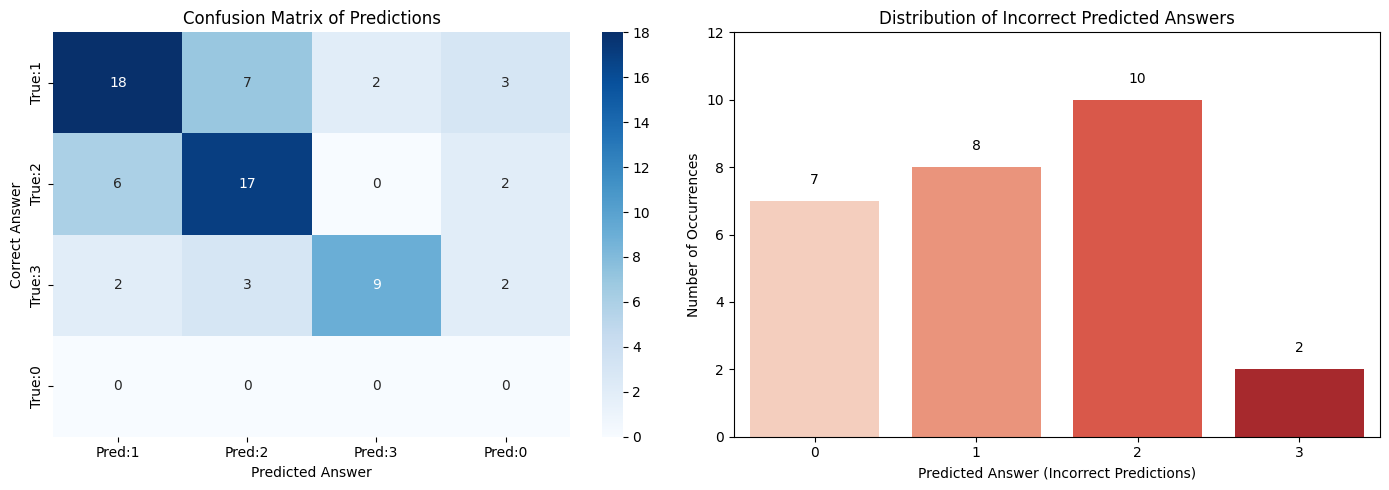

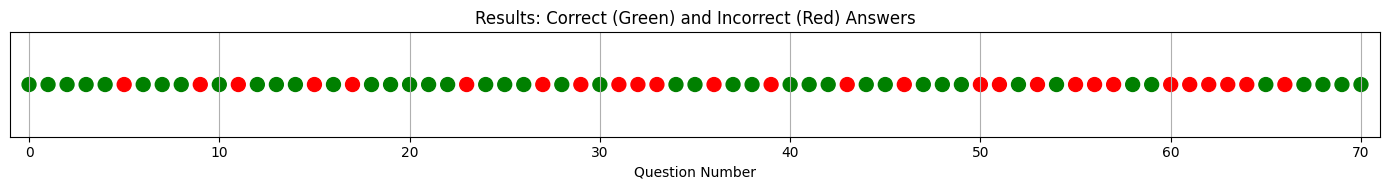

In [18]:
output_file_risposta_elaborata = "risposte_con_tag.txt"
df_risposta_elaborata, accuracy_risposta_elaborata = extract_dataframe_results(output_file_risposta_elaborata)
print(f"Total accuracy: {accuracy_risposta_elaborata}%")
visualize_results(df_risposta_elaborata)

## English Prompts

In [21]:
ASENG_agent_config = lr.ChatAgentConfig(
    llm=llm_config_AS,
    system_message="You are an agent that responds with a complete and detailed text to a question, \
        based on the results of a Google search.",
)

class AnswerScraperENG(lr.ChatAgent):
    def __init__(self):
        super().__init__(config=ASENG_agent_config)
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        chrome_options.add_argument("--no-sandbox")
        chrome_options.add_argument("--disable-dev-shm-usage")
        chrome_options.add_experimental_option("prefs", {
            "download.prompt_for_download": False,
            "download.default_directory": "/dev/null",  # Non-existent directory to prevent downloads
            "profile.default_content_setting_values.automatic_downloads": 2,  # Block automatic downloads
        })
        self.driver = webdriver.Chrome(service=Service("/usr/local/bin/chromedriver"), options=chrome_options)
    
    def search_google(self, query):
        google_url = f"https://www.google.com/search?q={query}"
        self.driver.get(google_url)

        # Accept the consent if present
        try:
            consent_button = self.driver.find_element(By.XPATH, "//button[contains(text(), 'Accetta tutto')]")
            consent_button.click()
        except:
            pass

        soup = BeautifulSoup(self.driver.page_source, "html.parser")

        # Extracting titles, descriptions, and URLs
        results = []
        for result in soup.find_all("div", class_="tF2Cxc"):
            title = result.find("h3")
            description = result.find("div", class_="VwiC3b")
            link = result.find("a")
            if title and description and link:
                title_text = title.get_text()
                description_text = description.get_text()
                url = link['href']
                results.append({"title": title_text, "description": description_text, "url": url})

        # Visit each URL and extract page content
        for result in results[:5]:
            try:
                self.driver.get(result["url"])
                time.sleep(2)
                page_soup = BeautifulSoup(self.driver.page_source, "html.parser")
                page_text = page_soup.get_text(separator="\n").strip()
                result["content"] = page_text[:500]
            except Exception as e:
                result["content"] = "Failed to retrieve content"
        
        return results
    
    def clean_data(self, data):
        '''
        Clean web searches given in input.
        '''
        cleaned_results = []
        for item in data:
            cleaned_item = {}
            
            cleaned_item['title'] = item.get('title', '').strip()
            cleaned_item['description'] = item.get('description', '').strip()
            cleaned_item['url'] = item.get('url', '').strip()
            
            content = item.get('content', '').strip()
            # Reduce multiple new lines to one
            content = re.sub(r'\n+', '\n', content)
            # Remove multiple white spaces
            content = re.sub(r'\s{2,}', ' ', content)

            content = content[:300] + '...' if len(content) > 300 else content
            cleaned_item['content'] = content
            
            cleaned_results.append(cleaned_item)
        return cleaned_results

    def find_unique_answer(self, results, question):
        """
        Analize the search results to find a unique correct answer.
        """
        if not results:
            return None
        
        combined_text = " ".join([result['title'] + " " + result['description'] for result in results])
        combined_text = f"Question:'{question}'\n\
                        Web search: {combined_text}"

        response = self.llm_response(combined_text)
        
        return response

    def get_answer(self, question):
        """
        Reformulates the question, performs a Google search, and returns the most relevant answer.
        """
        # Reformulate the question into a search query
        query = question.replace(" ", "+")

        # Perform the search and get top results
        results = self.search_google(query)
        results = self.clean_data(results)

        # Formulate a unique answer
        unique_answer = self.find_unique_answer(results, question)
        
        if unique_answer is None:
            return ""

        return str(unique_answer)[13:]

In [22]:
ACENG_agent_config = lr.ChatAgentConfig(
    llm=llm_config_AC,
    system_message="You are an agent tasked with answering a question by selecting the correct answer from three provided options. \
                    Respond immediately and only with the number (1, 2, or 3) corresponding to the correct answer, without adding comments or explanations. \
                    Your response must be only the number of the correct answer. \
                    Base your choice exclusively on the following inputs:\n \
                        - question\n \
                        - options\n \
                        - legal text\n \
                        - Google answer",
)

class AnswerCompilerENG(lr.ChatAgent):
    def __init__(self):
        super().__init__(config=ACENG_agent_config)

    def compile_answer(self, final_answer, final_text, question, choices):
        """
        Uses the LLM to compare the final_answer and final_text with the given choices and returns the correct answer.
        """

        combined_text = (f"question:{question}\n"
                    F"options:\n"
                    f"1) {choices[0]}\n"
                    f"2) {choices[1]}\n"
                    f"3) {choices[2]}\n\n"
                    f"legal text: {final_text}\n\n"
                    f"Google answer: {final_answer}\n\n"
                )

        response = self.llm_response(combined_text)
        response = str(response)[12:]

        # Extract the number of the correct answer from the response using regex
        correct_answer_number = None
        pattern = r'\b([123])\b'

       # Search for the answer where it should be 
        match = re.search(pattern, response[:5])
        if match:
            correct_answer_number = match.group(1)
        else:
            # Check the whole response in case the LLM does not immediatly respond with the number of the answer
            match = re.search(pattern, response)
            if match:
                correct_answer_number = match.group(1)
        if correct_answer_number is None:
            correct_answer_number = 0
        correct_answer_number = int(correct_answer_number)
        return correct_answer_number, response

In [ ]:
def agents_pipeline_ENG(single_data):
    regulatory_agent = ReferenceFinder()
    normattiva_exp = NormattivaExpert()
    answer_scraper = AnswerScraperENG()
    answer_compiler = AnswerCompilerENG()

    reference = regulatory_agent.process_question(single_data['question'])
    if reference:
        normattiva_text = normattiva_exp.fetch_legal_text(reference)
        if normattiva_text is None:
            normattiva_text = ''
    else:
        normattiva_text = ''
    final_answer = answer_scraper.get_answer(single_data['question'])
    
    correct_answer, llm_response = answer_compiler.compile_answer(final_answer, normattiva_text, single_data['question'], [single_data['answer1'], single_data['answer2'], single_data['answer3']])
    
    answer_compiler.clear_history()
    answer_scraper.clear_history()
    return correct_answer, llm_response, reference, normattiva_text, final_answer

def evaluate_data_ENG(filtered_data, out_file):
    correct_predictions = 0
    total_questions = len(filtered_data)

    for idx, data in enumerate(filtered_data):
        correct_answer = int(data['correct_answer'])
        predicted_answer, llm_response, reference, final_text, final_answer = agents_pipeline_ENG(data)
        if predicted_answer == correct_answer:
            correct_predictions += 1

        with open(out_file, "a") as f:
            f.write(f"DOMANDA {idx}: {data['question']}\n")
            f.write(f"SCELTE:\n1) {data['answer1']}\n2) {data['answer2']}\n3) {data['answer3']}\n")
            f.write(f"RISPOSTA CORRETTA: {correct_answer}\n\n")
            f.write(f"REFERENCE: {reference}\n\n")
            f.write(f"TESTO NORMATTIVA: {final_text}\n\n")
            f.write(f"RISPOSTA DA GOOGLE: {final_answer}\n\n")
            f.write(f"RISPOSTA LLM: {llm_response}\n\n")
            f.write(f"RISPOSTA FINALE: {predicted_answer}\n\n")
            f.write(f"RISPOSTE CORRETTE: {correct_predictions}/{idx+1}\n\n")
            f.write(200*'-')
            f.write("\n\n")

    accuracy = (correct_predictions / total_questions) * 100
    with open(out_file, "a") as f:
        f.write(f"ACCURACY: {accuracy:.2f}%\n\n")

output_file_ENG = "risposte_ENG.txt"

with open(output_file_ENG, "w") as f:
    f.write("")

evaluate_data_ENG(filtered_data, output_file_ENG)

Total accuracy: 60.56%


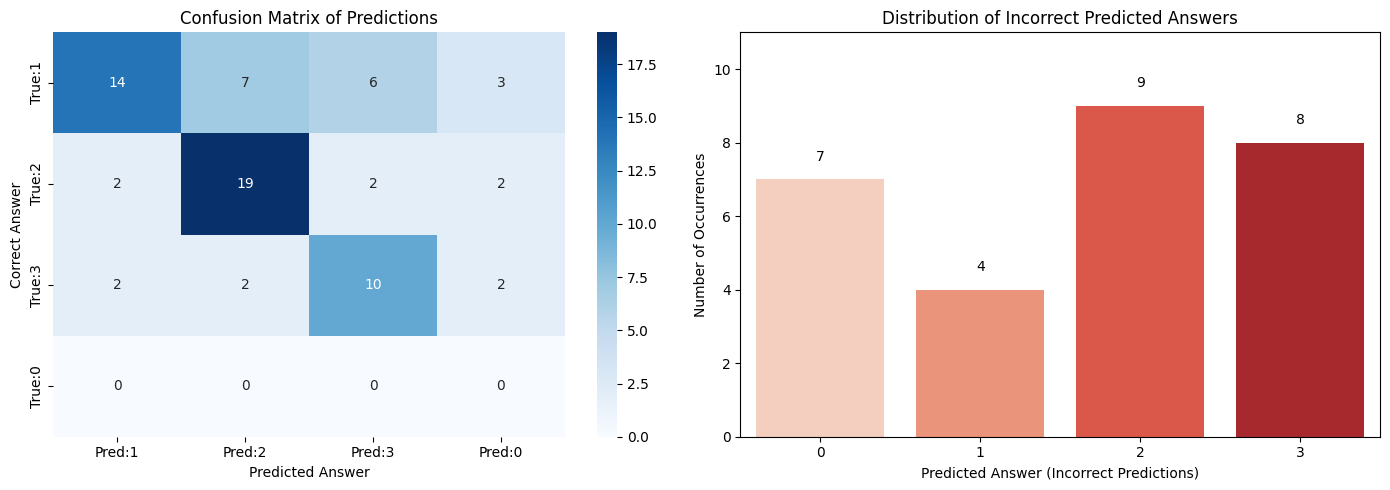

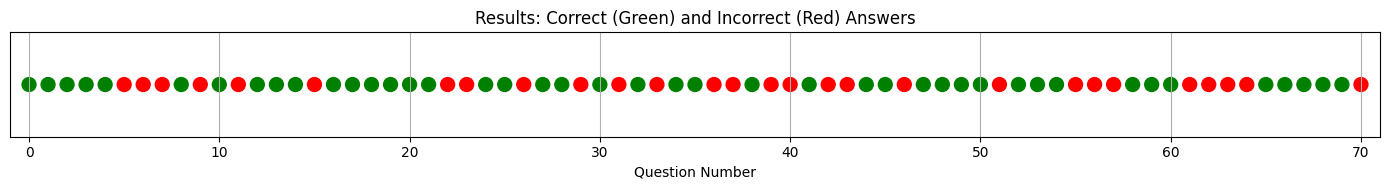

In [19]:
output_file_ENG = "risposte_ENG.txt"
df_ENG, accuracy_ENG = extract_dataframe_results(output_file_ENG)
print(f"Total accuracy: {accuracy_ENG}%")
visualize_results(df_ENG)

## Results comparison

### Accuracies

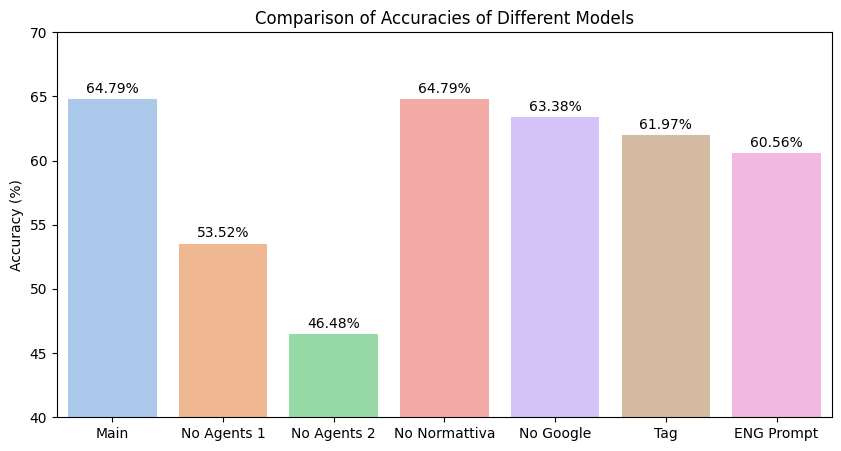

In [21]:
dataframes = [df_main, df_no_agents_1, df_no_agents_2, df_no_normattiva, df_no_google, df_risposta_elaborata, df_ENG]
accuracies = [accuracy_main, accuracy_no_agents_1, accuracy_no_agents_2, accuracy_no_normattiva, accuracy_no_google, accuracy_risposta_elaborata, accuracy_ENG]
labels = ['Main', 'No Agents 1', 'No Agents 2', 'No Normattiva', 'No Google', 'Tag', 'ENG Prompt']

def compare_accuracies(accuracies, labels=None):
    """
    Compare the accuracies of different models and visualize the results.
    """
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x=labels, y=accuracies, hue=labels, palette='pastel')

    # Annotate accuracy numbers on top of each bar
    for i, v in enumerate(accuracies):
        ax.text(i, v + 0.5, f"{v:.2f}%", color='black', ha='center')

    plt.title('Comparison of Accuracies of Different Models')
    plt.ylabel('Accuracy (%)')
    plt.ylim(40, 70)
    plt.show()

compare_accuracies(accuracies, labels)

This bar chart compares the accuracies of various configurations.
 * The "Main" model achieves the highest accuracy of 64.79%, tied with the "No Normattiva" model. Also, the "No Google" model predicts answers at the same level (only 1 correct prediction less).
 * Using the LLM without agents results in significant performance drops: "No Agents 1" achieves 53.52%, and "No Agents 2" further decreases to 46.48%, probably because it tends to allucinate while producing the sentence before the tag.
 * The "Tag" and "ENG Prompt" configurations maintain relatively good performance, with accuracies of 61.97% and 60.56%, respectively, but still fall short of the "Main" model, highlighting the effectiveness of give the LLM italian prompts and the difficulty that the LLM has while dealing with producing more text.
 
Overall, the chart emphasizes the importance of using a multi-agent system, giving some important context to the LLM.

### Zero Prediction Counts

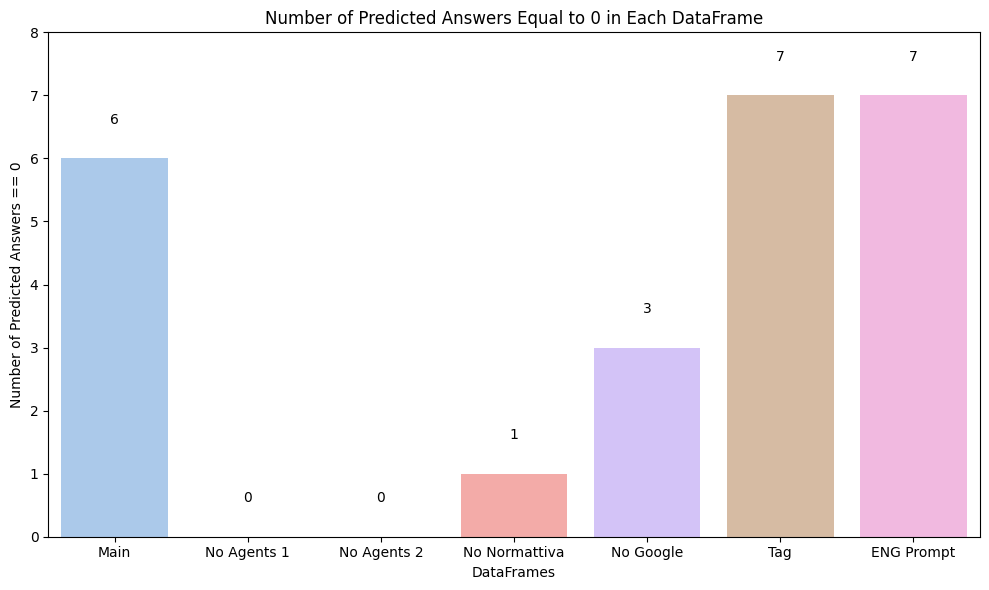

In [27]:
def plot_predicted_zero_counts(dataframes, labels=None):
    """
    Plots the number of predicted answers equal to 0 in each DataFrame.
    """
    zero_counts = [df[df['Predicted Answer'] == 0].shape[0] for df in dataframes]

    if labels is None:
        labels = [f'DataFrame {i+1}' for i in range(len(dataframes))]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=labels, y=zero_counts, hue=labels, palette='pastel')

    for i, count in enumerate(zero_counts):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

    plt.xlabel('DataFrames')
    plt.ylabel('Number of Predicted Answers == 0')
    plt.title('Number of Predicted Answers Equal to 0 in Each DataFrame')
    plt.ylim(0, max(zero_counts) + 1)

    plt.tight_layout()
    plt.show()

plot_predicted_zero_counts(dataframes, labels=labels)

This bar chart illustrates the number of times the LLM fails to produce a valid answer (0 predictions) across different configurations.<br>
 * The "Main", "Tag" and "ENG Prompt" configurations exhibit the highest failure rates, indicating that these setups are least reliable in consistently providing answers. That is probably because these configurations are the ones that give the LLM a longer prompt, having either the Normattiva Legal text and the Google Answer. These numbers indicate that the performances can probably be improved with the use of a bigger LLM that can deal better with long input text.
 * The trend of "long prompt --> more 0 predictions" is consistent also with the other configurations: the Normattiva Legal text tends to be longer than the Google Answer and therefore the configuration with only Normattiva Legal text produces more 0 predictions than the one with only the Google Answer.
 * According with the considerations done, the two configurations with no input text, only the basic prompt, are the ones that produce no 0 prediction.
 
 This chart underscores the trade-offs between accuracy and the ability to always generate a prediction.

### Answers

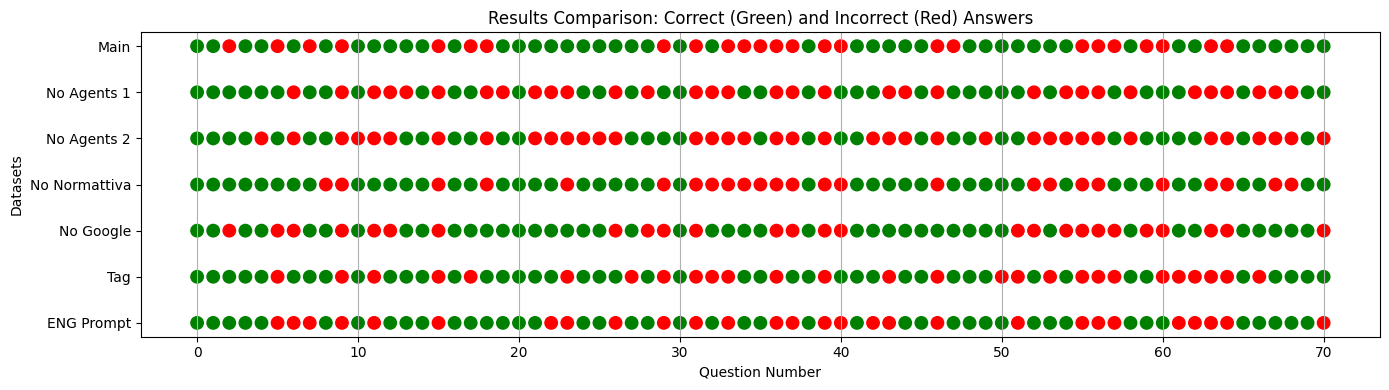

In [25]:
def plot_incorrect_answers_combined(dataframes, labels=None):
    """
    Plots the incorrect and correct answers for all dataframes in a unique graph,
    with vertical separation between datasets.
    """
    plt.figure(figsize=(14, 4))

    num_datasets = len(dataframes)
    y_offsets = list(range(num_datasets))

    for i, df in enumerate(reversed(dataframes)):
        df_sorted = df.sort_values('Index')
        colors = ['green' if is_correct else 'red' for is_correct in df_sorted['Is Correct']]
        y_values = [y_offsets[i]] * len(df_sorted)
        plt.scatter(df_sorted['Index'], y_values, c=colors, s=80, label=labels[num_datasets - i - 1] if labels else None)

    plt.xlabel('Question Number')
    plt.ylabel('Datasets')
    plt.title('Results Comparison: Correct (Green) and Incorrect (Red) Answers')
    plt.yticks(y_offsets, labels[::-1] if labels else [f'Dataset {i+1}' for i in y_offsets])
    plt.grid(axis='x')

    plt.tight_layout()
    plt.show()

plot_incorrect_answers_combined(dataframes, labels=labels)

This plot shows the correct and incorrect answers performed by each model. <br>
In particular, it can be seen that there are certain questions that are predicted in a wrong way by all the models or the majority of them. This is due to the question and multiple choice structures, being ambiguous, very similar or not simple to compute also thorugh the context given in input.

### Common Incorrect Predictions

In [26]:
def print_common_incorrect_predictions(dataframes):
    """
    Prints the rows that have incorrect predictions in all the given DataFrames.
    """
    incorrect_predictions = dataframes[0][dataframes[0]['Is Correct'] == False].copy()

    for df in dataframes[1:]:
        incorrect_predictions = incorrect_predictions.merge(
            df[df['Is Correct'] == False],
            on='Index',
            suffixes=('', '_other')
        )

    # Check if there are any common incorrect predictions
    if incorrect_predictions.empty:
        print("No common incorrect predictions found in all DataFrames.")
        return

    for _, row in incorrect_predictions.iterrows():
        print('-' * 80)
        print(f"Question {row['Index']}: {row['Question']}\n")
        print("Choices:")
        for i, choice in enumerate(row['Choices'], start=1):
            print(f"{i}) {choice}")
        print(f"\nCorrect Answer: {row['Correct Answer']}")

print_common_incorrect_predictions(dataframes)

--------------------------------------------------------------------------------
Question 9: quali tra questi non sono ufficiali di polizia giudiziaria ex art. 57 c.p.p.?

Choices:
1) i sovrintendenti
2) i commissari
3) i carabinieri

Correct Answer: 3
--------------------------------------------------------------------------------
Question 15: le risorse derivanti da tributi propri, compartecipazioni e fondo perequativo servono a comuni, province, città metropolitane e regioni per (art. 119 della costituzione):

Choices:
1) finanziare integralmente le funzioni pubbliche loro attribuite
2) finanziare solo in modo parziale le funzioni pubbliche loro attribuite
3) finanziare le funzioni fondamentali

Correct Answer: 3
--------------------------------------------------------------------------------
Question 31: tra i vari principi caratterizzanti il procedimento amminist rativo, quelli enunciati dalla legge n. 241 1990 dimostrano come il legislatore abbia inteso modellare l'a zione ammini

As underlined before, the common errors to all the models are the ones that have similar options as answers. <br>
For example, in question 9, all the three roles (sovrintendenti, commissari and carabinieri) are present in the Normattiva Legal text and Google Answer, so it can be difficult to evaluate the right one.

## Conclusions

This notebook explores a system designed to answer multiple-choice legal questions by combining LLMs with specialized agents. The system uses different agents to gather legal references, search the web, and process information to generate accurate answers. By working together, these agents improve the ability of the LLM to handle complex legal questions. 

The results show that the "Main" complete system achieved the highest accuracy, making it the most effective setup. However, even when certain agents were removed, the system still performed well, showing the fact that it is important to have some useful context. In the study there also tested simpler configurations where only the LLM was used without agents. These setups had lower accuracy and more errors, highlighting the importance of the agents in improving performance.<br>
One challenge identified was the issue of "zero predictions," where the system fails to choose an answer. This problem happened more often when the system had to process long and detailed prompts, such as those including both legal references and web search results. This suggests that using larger, more advanced LLMs or improving how the system presents information to the model could help reduce these errors.

Overall, this project demonstrates that combining agents with LLMs is a powerful approach for solving difficult tasks like legal question answering. The results provide valuable insights into how these systems can be improved further, such as by refining the agents, optimizing the way information is structured and presented to the model, or maybe add some fine-tuning in the legal domain.